In [17]:
# Neuroninių tinklų modelių palyginimas
#
# Šiame notebook palyginsime skirtingus neuroninius tinklus ir ML modelius Bitcoin kainai prognozuoti.

In [18]:
# Reikalingų bibliotekų importavimas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

# Atsitiktinių skaičių generatoriaus sėkla atkartojamumui
np.random.seed(42)

In [19]:
# Užkrauname neuroninių tinklų modelių metrikas su saugumu
# Jei failų nėra, pateikiamas aiškus pranešimas

models_dir = '../../models'

lstm_info = None
gru_info = None

try:
    with open(f'{models_dir}/lstm_model_info.json', 'r') as f:
        lstm_info = json.load(f)
    print("LSTM modelio metrikos:")
    for metric, value in lstm_info['metrics'].items():
        print(f"  {metric}: {value}")
except FileNotFoundError:
    print("LSTM modelio metrikų failas nerastas! Paleiskite LSTM notebook'ą ir įsitikinkite, kad modelio informacija išsaugota.")

try:
    with open(f'{models_dir}/gru_model_info.json', 'r') as f:
        gru_info = json.load(f)
    print("\nGRU modelio metrikos:")
    for metric, value in gru_info['metrics'].items():
        print(f"  {metric}: {value}")
except FileNotFoundError:
    print("GRU modelio metrikų failas nerastas! Paleiskite GRU notebook'ą ir įsitikinkite, kad modelio informacija išsaugota.")

LSTM modelio metrikų failas nerastas! Paleiskite LSTM notebook'ą ir įsitikinkite, kad modelio informacija išsaugota.

GRU modelio metrikos:
  mse: 105871.87685574578
  rmse: 325.3795888738963
  mae: 224.63801517948983
  r2: 0.9984264324592508
  mape: 0.2522747901127449


In [20]:
# Užkrauname ML modelių metrikas, jei jos yra
try:
    with open(f'{models_dir}/ml_models_info.json', 'r') as f:
        ml_models_info = json.load(f)
    print("\nML modelių metrikos:")
    for model_name, metrics in ml_models_info.items():
        print(f"  {model_name}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value}")
    rf_info = ml_models_info.get('RandomForest', {'metrics': {'rmse': None, 'mape': None}})
    xgb_info = ml_models_info.get('XGBoost', {'metrics': {'rmse': None, 'mape': None}})
    ml_models_available = True
except FileNotFoundError:
    print("\nML modelių metrikų failas nerastas.")
    rf_info = {'metrics': {'rmse': None, 'mape': None}}
    xgb_info = {'metrics': {'rmse': None, 'mape': None}}
    ml_models_available = False


ML modelių metrikų failas nerastas.


In [21]:
# Vizualizuojame RMSE palyginimą tarp modelių
# Jei nėra bent vieno neuroninio tinklo modelio, vizualizacija nevykdoma

models = []
rmse_values = []

if lstm_info is not None:
    models.append('LSTM')
    rmse_values.append(lstm_info['metrics']['rmse'])
if gru_info is not None:
    models.append('GRU')
    rmse_values.append(gru_info['metrics']['rmse'])

if ml_models_available:
    if rf_info['metrics']['rmse'] is not None:
        models.append('RandomForest')
        rmse_values.append(rf_info['metrics']['rmse'])
    if xgb_info['metrics']['rmse'] is not None:
        models.append('XGBoost')
        rmse_values.append(xgb_info['metrics']['rmse'])

if len(models) >= 2:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, rmse_values, color=['blue', 'green', 'orange', 'red'][:len(models)])
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')
    plt.title('Modelių RMSE palyginimas (mažesnė reikšmė = geriau)')
    plt.ylabel('RMSE')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Nepakanka modelių RMSE vizualizacijai (reikia bent dviejų).")

Nepakanka modelių RMSE vizualizacijai (reikia bent dviejų).


In [22]:
# Vizualizuojame MAPE palyginimą tarp modelių
models = []
mape_values = []

if lstm_info is not None:
    models.append('LSTM')
    mape_values.append(lstm_info['metrics']['mape'])
if gru_info is not None:
    models.append('GRU')
    mape_values.append(gru_info['metrics']['mape'])

if ml_models_available:
    if rf_info['metrics']['mape'] is not None:
        models.append('RandomForest')
        mape_values.append(rf_info['metrics']['mape'])
    if xgb_info['metrics']['mape'] is not None:
        models.append('XGBoost')
        mape_values.append(xgb_info['metrics']['mape'])

if len(models) >= 2:
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, mape_values, color=['blue', 'green', 'orange', 'red'][:len(models)])
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%',
                 ha='center', va='bottom')
    plt.title('Modelių MAPE palyginimas (mažesnė reikšmė = geriau)')
    plt.ylabel('MAPE (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Nepakanka modelių MAPE vizualizacijai (reikia bent dviejų).")

Nepakanka modelių MAPE vizualizacijai (reikia bent dviejų).


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


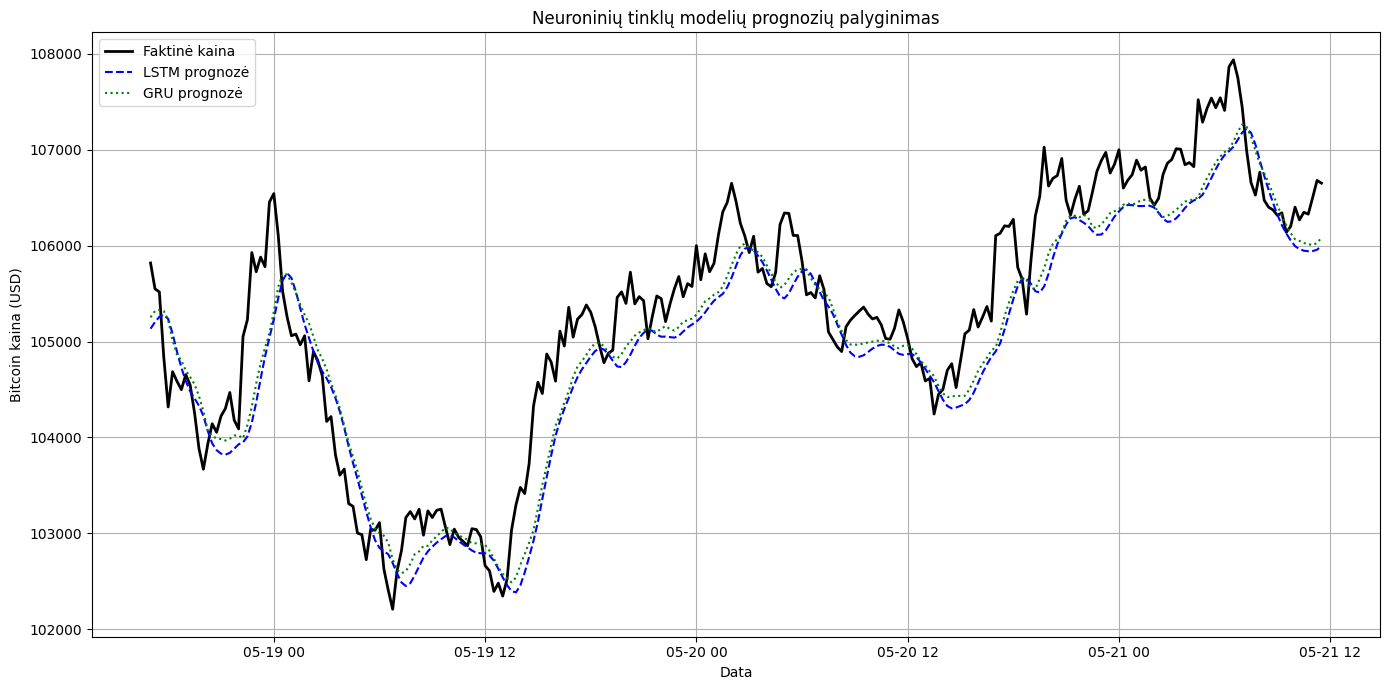

In [23]:
# Vizualizuojame neuroninių tinklų modelių prognozes, jei abu modeliai yra
from tensorflow.keras.models import load_model
import time

if lstm_info is not None or gru_info is not None:
    # Funkcija prognozių atstatymui į originalią skalę
    def inverse_transform_predictions(predictions, scaler, target_idx=3, feature_columns=None):
        dummy = np.zeros((len(predictions), len(feature_columns)))
        dummy[:, target_idx] = predictions.flatten()
        inverse_predicted = scaler.inverse_transform(dummy)
        return inverse_predicted[:, target_idx]

    import pickle
    scaler_path = f'{models_dir}/lstm_scaler.pkl'
    if not os.path.exists(scaler_path):
        scaler_path = f'{models_dir}/gru_scaler.pkl'
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # Užkrauname originalius duomenis iš Binance API
    import requests
    from datetime import datetime, timedelta

    BINANCE_API_URL = "https://api.binance.com/api/v3/klines"
    def get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=None, end_time=None):
        if end_time is None:
            end_time = datetime.now()
        if start_time is None:
            start_time = end_time - timedelta(days=14)
        start_ts = int(start_time.timestamp() * 1000)
        end_ts = int(end_time.timestamp() * 1000)
        all_klines = []
        current_start = start_ts
        while current_start < end_ts:
            params = {
                'symbol': symbol,
                'interval': interval,
                'startTime': current_start,
                'endTime': end_ts,
                'limit': 1000
            }
            try:
                response = requests.get(BINANCE_API_URL, params=params)
                response.raise_for_status()
                klines = response.json()
                if not klines:
                    break
                all_klines.extend(klines)
                current_start = int(klines[-1][0]) + 1
                time.sleep(0.5)
            except Exception as e:
                print(f"Klaida gaunant duomenis: {str(e)}")
                time.sleep(2)
        if all_klines:
            columns = ['time', 'open', 'high', 'low', 'close', 'volume', 
                       'close_time', 'quote_asset_volume', 'number_of_trades',
                       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
            df = pd.DataFrame(all_klines, columns=columns)
            df['time'] = pd.to_datetime(df['time'], unit='ms')
            numeric_columns = ['open', 'high', 'low', 'close', 'volume']
            df[numeric_columns] = df[numeric_columns].astype(float)
            return df
        return None

    end_time = datetime.now()
    start_time = end_time - timedelta(days=14)
    df = get_historical_klines(symbol="BTCUSDT", interval="15m", start_time=start_time, end_time=end_time)
    df = df.sort_values('time')
    columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']
    feature_columns = columns_to_normalize
    target_column = 'close'
    sequence_length = 10

    # Normalizuojame duomenis
    df_normalized = df.copy()
    df_normalized[columns_to_normalize] = scaler.transform(df[columns_to_normalize])

    # Sukuriame sekas kaip treniruojant modelius
    def create_sequences(data, target_column, sequence_length):
        X, y = [], []
        data_array = data[feature_columns].values
        target_idx = feature_columns.index(target_column)
        for i in range(len(data) - sequence_length):
            X.append(data_array[i:i + sequence_length])
            y.append(data_array[i + sequence_length, target_idx])
        return np.array(X), np.array(y)

    X, y = create_sequences(df_normalized, target_column, sequence_length)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    target_idx = feature_columns.index(target_column)

    lstm_preds_original = None
    gru_preds_original = None

    try:
        lstm_model = load_model(f'{models_dir}/lstm_model.h5')
        lstm_preds = lstm_model.predict(X_test)
        lstm_preds_original = inverse_transform_predictions(lstm_preds, scaler, target_idx, feature_columns)
    except Exception as e:
        print(f"Nepavyko užkrauti LSTM modelio: {e}")

    try:
        gru_model = load_model(f'{models_dir}/gru_model.h5')
        gru_preds = gru_model.predict(X_test)
        gru_preds_original = inverse_transform_predictions(gru_preds, scaler, target_idx, feature_columns)
    except Exception as e:
        print(f"Nepavyko užkrauti GRU modelio: {e}")

    y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, target_idx, feature_columns)
    test_dates = df['time'].iloc[-len(y_test):].reset_index(drop=True)

    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='black', linewidth=2)
    if lstm_preds_original is not None:
        plt.plot(test_dates, lstm_preds_original, label='LSTM prognozė', color='blue', linestyle='--')
    if gru_preds_original is not None:
        plt.plot(test_dates, gru_preds_original, label='GRU prognozė', color='green', linestyle=':')
    plt.title('Neuroninių tinklų modelių prognozių palyginimas')
    plt.xlabel('Data')
    plt.ylabel('Bitcoin kaina (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Nėra pakankamai neuroninių tinklų modelių prognozių vizualizacijai.")

In [24]:
# Išvados apie modelių palyginimą
print("Neuroninių tinklų modelių palyginimo išvados:")
print("--------------------------------------------")

if lstm_info is not None and gru_info is not None:
    # Palyginame RMSE
    if lstm_info['metrics']['rmse'] < gru_info['metrics']['rmse']:
        best_model_rmse = "LSTM"
    else:
        best_model_rmse = "GRU"
    print(f"Pagal RMSE metriką geriausias yra {best_model_rmse} modelis.")

    # Palyginame MAPE
    if lstm_info['metrics']['mape'] < gru_info['metrics']['mape']:
        best_model_mape = "LSTM"
    else:
        best_model_mape = "GRU"
    print(f"Pagal MAPE metriką geriausias yra {best_model_mape} modelis.")

    # Bendra išvada
    print("\nBendra išvada:")
    if best_model_rmse == best_model_mape:
        print(f"{best_model_rmse} modelis yra geriausias pagal abi metrikes.")
    else:
        print(f"Skirtingos metrikos rodo skirtingus geriausius modelius: RMSE - {best_model_rmse}, MAPE - {best_model_mape}.")

    # Palyginimas su ML modeliais, jei jie yra
    if ml_models_available:
        print("\nPalyginimas su klasikiniais ML modeliais:")
        nn_best_rmse = min(lstm_info['metrics']['rmse'], gru_info['metrics']['rmse'])
        ml_best_rmse = min([v['metrics']['rmse'] for k, v in ml_models_info.items() if v['metrics']['rmse'] is not None], default=float('inf'))
        if nn_best_rmse < ml_best_rmse:
            print("Neuroniniai tinklai parodė geresnį tikslumą nei klasikiniai ML modeliai.")
        else:
            print("Klasikiniai ML modeliai parodė geresnį arba panašų tikslumą lyginant su neuroniniais tinklais.")
else:
    print("Nepavyko palyginti, nes trūksta bent vieno neuroninio tinklo modelio metrikų.")

Neuroninių tinklų modelių palyginimo išvados:
--------------------------------------------
Nepavyko palyginti, nes trūksta bent vieno neuroninio tinklo modelio metrikų.
